# MOSViz jdaviz concept

This notebook provides a *concept* of how the mosviz data-loading and basic interaction workflow operates.

In [ ]:
from jdaviz.app import Application

mosapp = Application('mosviz')
mosapp

The MOSViz app should now appear in the output of the cell above, although initially with no data loaded. 

The below is a hacked-together matplotlib layout that shows how the viewers should be laid out (although initially it would appear without data).

In [1]:
import numpy as np
from matplotlib import pyplot as plt

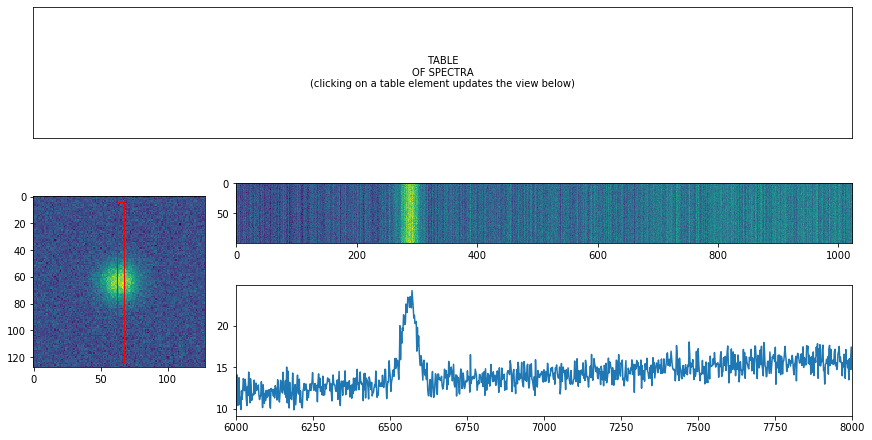

In [4]:
fake_x = np.linspace(6000, 8000, 1024)
fake_y = np.random.randn(len(fake_x)) + 10*np.exp(-0.001*(fake_x-6563)**2) + fake_x/500
fake_2d = fake_y[np.newaxis] + np.random.randn(100, 1024)
fake_r_im = np.sum((np.mgrid[:128, :128]-64)**2,axis=0)**0.5
fake_im = np.random.randn(128, 128) + np.exp(-0.005*fake_r_im**2)*10

fig = plt.figure(constrained_layout=True, figsize=(12, 6))
gs = fig.add_gridspec(3, 3)

ax_im = fig.add_subplot(gs[1:, :1])
ax_im.imshow(fake_im)
ax_im.add_artist(plt.Rectangle((62, 4), 5, 120, edgecolor='red', facecolor='none'))
ax_2d = fig.add_subplot(gs[1, 1:])
ax_2d.imshow(fake_2d)
ax_1d = fig.add_subplot(gs[2, 1:])
ax_1d.plot(fake_x, fake_y)
ax_1d.set_xlim(fake_x[0], fake_x[-1])
ax_table = fig.add_subplot(gs[0, :])
ax_table.text(0.5, 0.5, 'TABLE\nOF SPECTRA\n(clicking on a table element updates the view below)', ha='center', va='center')
ax_table.set_xticks([])
ax_table.set_yticks([]);

# Loading data 

## Load JWST (NIRSpec) data 

Ideallly JWST NIRSpec MSA data should just be as simple as:

In [ ]:
mosapp.load_data('/path/to/downloaded/nirspec/data')

And that should load up *everything* - images, spectra, and the data table.

## Load other MOS data

For other data sets MOSViz doesn't natively understand, the user will have to provide the data directly. It should be possible to load things piecemeal, and just have only the relevant viewers "recognize" their existence.  They should leverage astropy objects where possible so that the I/O doesn't have to be re-implemented:

In [ ]:
from specutils import SpectrumCollection

# this also be a complicated data-loading cell, but the result should be a SpectrumCollection with N spectra
spectra = SpectrumCollection.read('/path/to/my/deimos/spectra')
mosapp.load_spectra(spectra)

This would activate the 1d spectrum view and the table view (which would just have a single column like "index") but not the image or 2d spectrum view.  This is the "minimally useful" MOSViz. If the user also has 2d spectra available, they can do:

In [ ]:
from astropy.nddata import CCDData

spectra2d = []
for fn in filenames_2dspectra: #filenames_2dspectra is an array of length N, in the *same order* as the SpectrumCollection
    # CCDData should or at least NDData should be the internal representation, but potentially the user
    # can just pass in a raw numpy array if they don't want to bother with NDData stuff.  But then we
    # have to construct the WCS assuming a pixel-to-pixel 
    spectra2d.append(CCDData.read(fn))

mosapp.load_2d_spectra(spectra2d)

Doing the above then activates the 2d spectrum part of the view.  If the 2d spectra have wcs, the wcs is used to tie the 1d and 2d spectra together.  If not, assume a pixel-to-pixel mapping along the x-axis of the spectrum and the images.

A similar idiom works for the 2d images:

In [ ]:
images = []
for fn in filenames_images: #filenames_images is an array of length N, in the *same order* as the SpectrumCollection
    # CCDData should or at least NDData should be the internal representation, but potentially the user
    # can just pass in a raw numpy array if they don't want to bother with NDData stuff
    images.append(CCDData.read(fn))

mosapp.load_images(images)

The assumption given no other information is that the center of the image is the center of the slit.  But until the data table is loaded we can't do anything with that, so it just shows the image as-is at this point.

Additionally *or* independently from the 2d spectra/image lists, the user can provide the table:

In [ ]:
from astropy import Table

table = Table.read('/path/to/my/slit/catalog.ecsv')  # the table must have the same number of rows as spectra in the SpectrumCollection
mosapp.load_table(table) 

Now the table viewer would show all columns in the table in the table viewer.  Additionally, the 2d image view should now be updated based on the presence of certain columns in the table.  Specifically:

* if there is a `SkyCoord` object in the table (probably with a special name like 'coordinates'), the 2d image view should be centered on that coordinate by default.
* columns defining slit geometry should lead to a slit appearing in the image view.  This would be perhaps "slit_width", "slit_height", and "slit_angle".  They would all need to have units, and then `astropy.regions` can be used to actually make the slits.

*Question: how well does this map to NIRSpec data's slit information?  I'm fairly sure that's embedded in the spectrum itself.  So probably the rule is that if there's slit information in the spectrum, use that, but if there's *also* table information, that takes precedence because the user likely put it in intentionally to override the spectrum?*

### Alternative approach to loading with a "master table"

If for whatever reason the above approach does not work, the data table itself can be viewed as a "master dataset".  Assuming the data objects are already loaded as above, that would look something like this:

In [ ]:
table = Table.read('/path/to/my/slit/catalog.ecsv')

table['mosviz_spectra'] = spectra
table['mosviz_2d_spectra'] = spectra2d
table['mosviz_images'] = images

mosapp.load_data(table)

Which would load the same state as the three method calls above.  If a user wanted the "limited" version (i.e., missing images or 2d spectra), they just don't add the relevant column to the table.

This works because Astropy has a concept of "mixin columns" which let python objects with the appropriate leading dimension masquerade as table columns, so this might basically work as-is.  But it's not clear to me that all of the necessary data types support mixin columns right now, so this might require substantial underlying library work.

## Custom loaders for "other" data 

We should support the option of using an I/O registry for custom loaders.  So then a user can write I/O functions like this:

In [ ]:
from glob import glob

@jdaviz.mosvizloader
def deimos_loader(mosvizapp, data_directory):
    spectrafn = glob(data_directory + _name'spec1d*.fits')
    SpectrumCollection([Spectrum1d.read(fn) for fn in spectrafn])
    
    spectra2dfns = glob(data_directory + _name'spec2d*.fits')
    spectra2d = [CCDData.read(fn, unit=u.adu) for fn in spectra2dfns]
    
    # there's no "standard" image format for deimos data, so we don't include images
    
    table = Table.read(data_directory + 'zspec.fits')
    
    mosvizapp.load_spectra(spectra)
    mosvizapp.load_2d_spectra(spectra2d)
    mosvizapp.load_table(table) 

Which they would use like:

In [ ]:
mosapp.load_data('/path/to/deimos/data/directory', format='deimos')

And then have it load the state just like the above.  They might then optionally do their own custom:

In [ ]:
mosapp.load_images(images)

Which is science case-specific because there's no standard format.

Then we can encourage users to contribute their own loaders to `jdaviz` and build a library of community-provided MOS viewers, just like for `specutils` and the astropy I/O machinery.

# Important UI interactions

## Table interactions

* When the user clicks on a table row, that should update the other views to show the spectrum from the selected row
* At least some columns should be editable, e.g. a "redshift" column or a "spectrum quality" column, which the user should be able to access and write out the table like this:

In [ ]:
tab = mosapp.get_data('table')
tab['redshift']  #<- a regular Astropy table column but with whatever the current state of the table in the UI
tab.write('output.ecsv')  

* In the desktop app (but *not* the notebook, if possible) there can be a save button that does exactly the above cell.

## Spectrum interactions

* When the 1d spectrum is zoomed along the x axis, the 2d spectrum should be matched to it (and vice versa).  Y-axis of both should be independent.

## Keyboard interactions

* There need to be keyboard shortcuts ('{'/'}', or '<'/'>'?  Or tab/ctrl-tab?) that advance to the next spectrum.
* There needs to be a way to quickly update a column in a table. e.g. you press "1" to label it quickly as "good spectrum" or "2" as "bad spectrum". (this might be a plugin?)
* The user should be able to customize that "quickly update column".  As a suggestion for how this might work:

In [ ]:
mosapp.set_keyboard_column_mappings({'1': ('spectrum_quality', 'good'), '2': ('spectrum_quality', 'bad'), })

Which tells mosviz that when the user presses the '1' key, that row's 'spectrum_quality' column should be updated with the value 'good', whereas '2' should update it to 'bad'.

* This custom mapping might also be implemented as a plugin, but that should come *after* getting the notebook version working.

# Additional notebook Glue selection interactions 

If the user wants the "full power" of Glue working with the table, a quick pathway is to have them create additional viewers to create subsets.  For example, suppose the `table` has two rows, one for 'rmag' and another for 'gmag', indicating the 'r' and 'g'-band magnitudes of the objects the spectra are of.  The user could then do:

In [ ]:
tab = mosapp.get_data('table')
tab['color'] = tab['gmag'] - tab['rmag']  #<- this should update the data table...

mosapp.scatter2d('color', 'rmag')

Now the user can use glue's selection capabilities to draw a box around a part of the color-magnitude diagram, which highlights only those in the MOSViz UI.

Initially this would *replace* the "small panel" of the Qt MOSviz with all the glue capabilities.  But eventually we would want this workflow to be possible using the more "general" Glue UI when that's working.